In [1]:
import pycomlink as pycml
import xarray as xr
import matplotlib.pyplot as plt

# Load example data

In [2]:
data_path = pycml.io.examples.get_example_data_path()
cmls = xr.open_dataset(data_path + '/example_cml_data.nc')

In [3]:
ds_radar = xr.open_dataset(data_path + '/example_areal_reference_data.nc')

# Calculate intersection weights

Note that the intersection weights are stored as `sparse.arrays` in a `xarray.DataArray` because the matrix of intersection weights for each CMLs, based on the radar grid, contains mostly zeros. Hence, we can save a lot of space. For large CML networks this is crucial because storing thousands of intersection weight matrices, one for each CML, easily eats up 10s of GBs of memory.

Note that this calculation is fairly fast, i.e. approx. 2 seconds for 500 CMLs.

In [4]:
%%time 

da_intersect_weights = pycml.spatial.grid_intersection.calc_sparse_intersect_weights_for_several_cmls(
    x1_line=cmls.site_a_longitude.values,
    y1_line=cmls.site_a_latitude.values,
    x2_line=cmls.site_b_longitude.values,
    y2_line=cmls.site_b_latitude.values,
    cml_id=cmls.cml_id.values,
    x_grid=ds_radar.longitudes.values,
    y_grid=ds_radar.latitudes.values,
    grid_point_location='lower_left',
)

CPU times: user 2.34 s, sys: 31.3 ms, total: 2.37 s
Wall time: 2.45 s


In [5]:
da_intersect_weights

Format,coo
Data Type,float64
Shape,"(500, 190, 228)"
nnz,4844
Density,0.00022363804247460756
Read-only,True
Size,151.4K
Storage ratio,0.0


# Plot intersection weights and CML path

Note that the lon-lat of the radar grid have been rounded in this example dataset and hence there are some strange pixel size, stemming from the non-equidistant lon-lat grids of the original radar data.

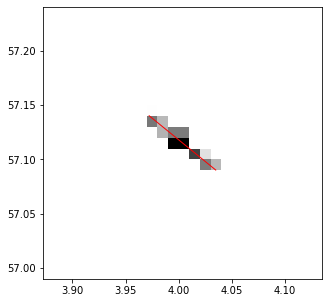

In [6]:
i = 22

fig, ax = plt.subplots(figsize=(5, 5))
ax.pcolormesh(
    ds_radar.longitudes.values,
    ds_radar.latitudes.values, 
    da_intersect_weights.isel(cml_id=i).to_numpy()[:-1, :-1],
    shading='flat',
    cmap='Greys',
)

cml = cmls.isel(cml_id=i)
plt.ylim(
    min(cml.site_a_latitude.values, cml.site_b_latitude.values) - 0.1,
    max(cml.site_a_latitude.values, cml.site_b_latitude.values) + 0.1,
)
plt.xlim(
    min(cml.site_a_longitude.values, cml.site_b_longitude.values) - 0.1,
    max(cml.site_a_longitude.values, cml.site_b_longitude.values) + 0.1,
)

def plot_cml_lines(ds_cmls, ax):
    ax.plot(
        [ds_cmls.site_a_longitude, ds_cmls.site_b_longitude],
        [ds_cmls.site_a_latitude, ds_cmls.site_b_latitude],
        'r',
        linewidth=1,
    )
    
plot_cml_lines(ds_cmls=cmls.isel(cml_id=i), ax=plt.gca())

# Get time series of radar rainfall along CML for each CML

This is internally done via a `sparase.tensordot` product, which is very fast, given that the intersection weights are also stored as `sparse.arrays`. The convenience funtion from `pycomlink` used here, also takes care of adding the correct coordinates to the `xarray.DataArray` that is returned.

Note that this calculation is very fast and can be done with a large number of CMLs and a much longer period of radar data. 

In [7]:
%%time 

da_radar_along_cmls = pycml.spatial.grid_intersection.get_grid_time_series_at_intersections(
    grid_data=ds_radar.rainfall_amount,
    intersect_weights=da_intersect_weights,
)

CPU times: user 1.92 s, sys: 754 ms, total: 2.67 s
Wall time: 2.51 s


In [8]:
da_radar_along_cmls

<xarray.DataArray (time: 3168, cml_id: 500)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * time     (time) datetime64[ns] 2018-05-10 ... 2018-05-20T23:55:00
  * cml_id   (cml_id) object '0' '1' '2' '3' '4' ... '496' '497' '498' '499'

In [9]:
# The following show how you write the data to a NetCDF to use it somewhere else.
# This is how the path-averaged reference data in the example data directory was produced.
#
# da_radar_along_cmls.to_dataset(name='rainfall_amount').to_netcdf(
#    '../pycomlink/io/example_data/example_path_averaged_reference_data.nc',
#    encoding={'rainfall_amount': {'zlib': True}}
#)

# Plot radar along CML vs. TRSL

We set non-meaningfull RSL and TSL values to NaN.

Here we only plot radar rain rates vs TRSL. For plotting CML-derived rain rates, processing has to be done first, which is e.g. shown in the notebook with the basic processing workflow. But also the comparison with TRSL already shows how good CML-data corresponds to rainfall data.

(we might add this processing here later...)

In [10]:
cmls['tsl'] = cmls.tsl.where(cmls.tsl < 100)
cmls['rsl'] = cmls.rsl.where(cmls.rsl > -99)

cmls['trsl'] = cmls.tsl - cmls.rsl

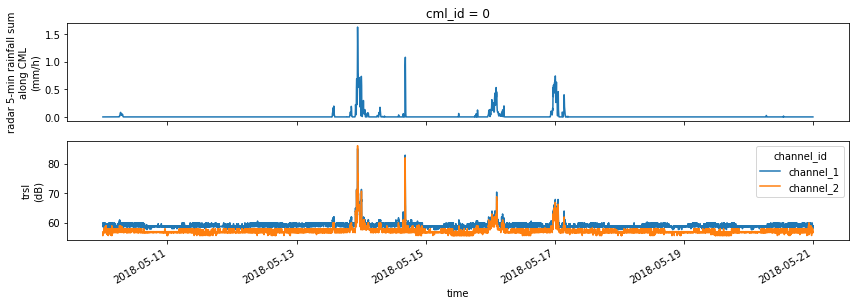

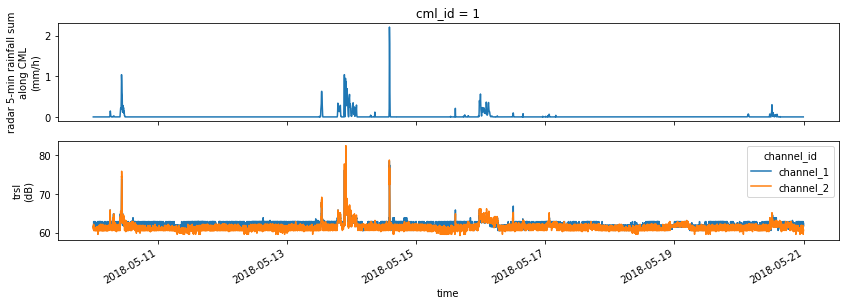

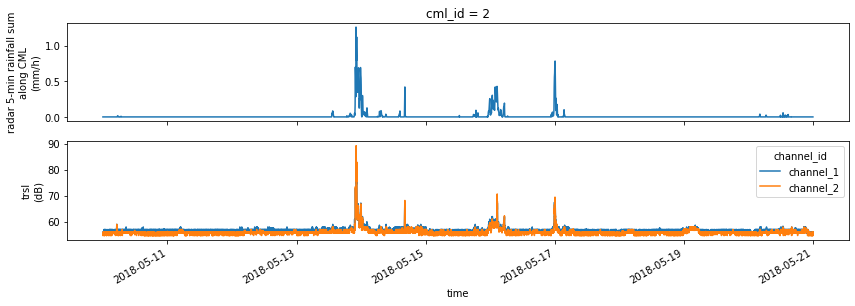

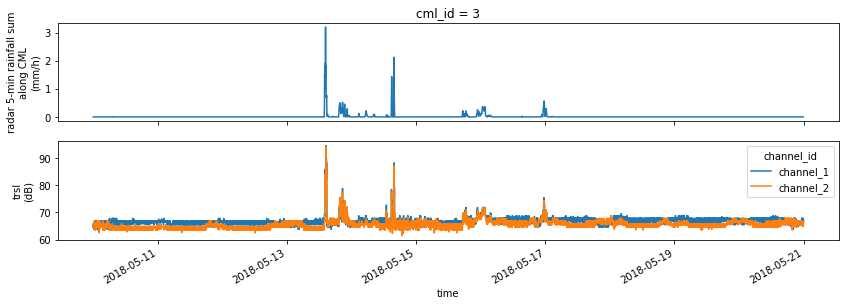

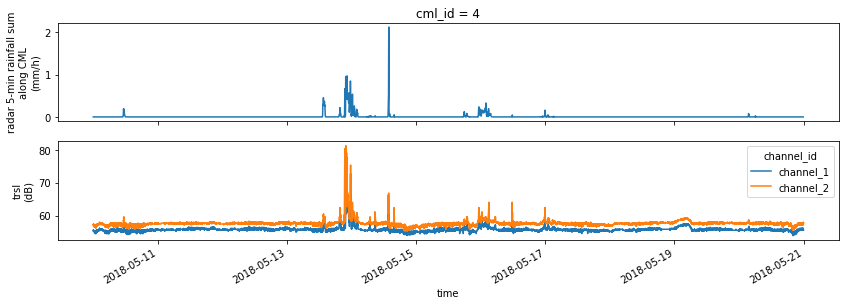

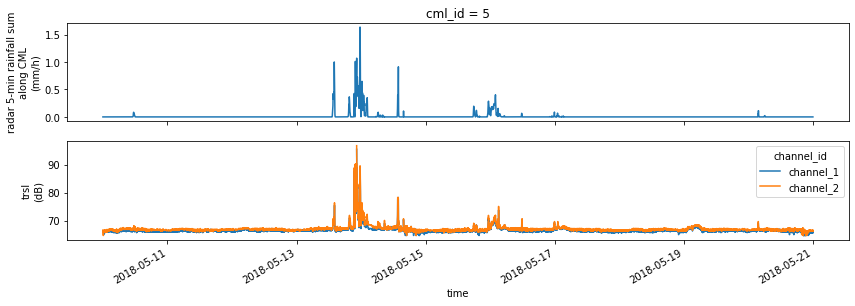

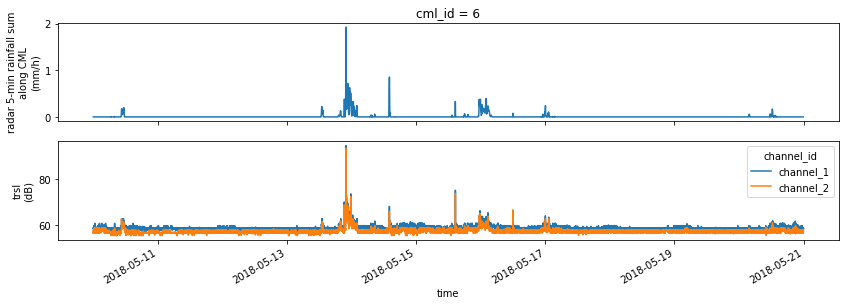

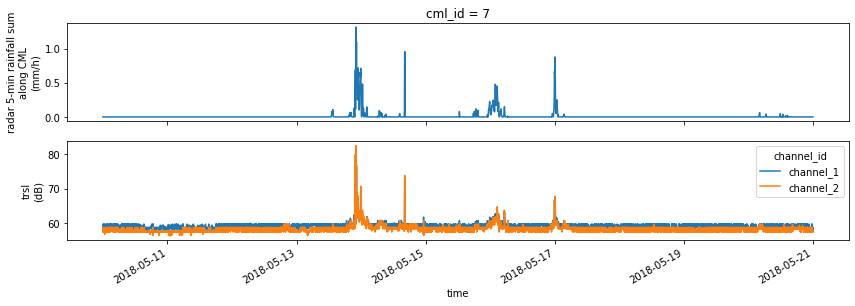

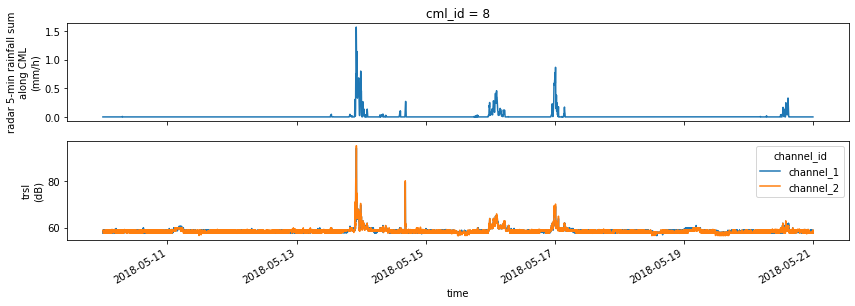

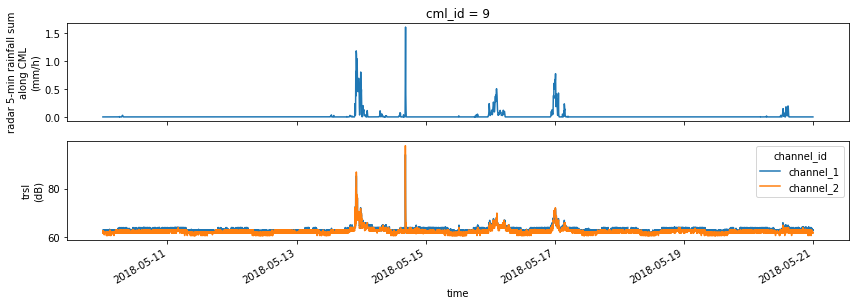

In [11]:
for i in range(10):
    fig, axs = plt.subplots(2, 1, figsize=(14,4), sharex=True)
    da_radar_along_cmls.isel(cml_id=i).plot(ax=axs[0])
    cmls.isel(cml_id=i).trsl.plot.line(x='time', ax=axs[1])
    axs[0].set_xlabel('')
    axs[0].set_ylabel('radar 5-min rainfall sum\nalong CML\n(mm/h)')
    axs[1].set_title('')
    axs[1].set_ylabel('trsl\n(dB)')
